In [1]:
%matplotlib inline
import glob
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib as mpl
from scipy import interpolate

plt.style.use('seaborn-paper')
mpl.rcParams.update({'font.size': 16})
font_size = 12
plt.rcParams["font.family"] = "Times New Roman"

# STIS Temperature Sensitivity in Time

This notebook details some initial results of looking into how the STIS dark rate temperature sensitivity curve (hereby referred to as the scale value curve) has evolved in time. As with much of the other code in this repository, this notebook is dependent on directories on my local machine, however this compiled notebook serves as a guide if anyone ever desires to reproduce this work as well. In the future, there are plans to introduces hooks in GitHub allowing access to HST data without direct binary hosting in the repository. Whenever that comes around, I hope to update this repository for better accessibility.

In [44]:
#Read in output files of darkrate_housingtemp.py

#Code(unfortunately) relies on naming scheme of these files to pull date metadata
# --- Convention is YYYY_mm(start)_YYYY_mm(end), usually a 3 month difference involving 2-4 anneal periods

imdir = "results_v3/"
lograte_regions = np.linspace(-2.5,1,15)
region_rates = [np.array([]) for _ in range(len(lograte_regions))]
region_errs = [np.array([]) for _ in range(len(lograte_regions))]
dt_mid = []

#Iterate through all available output files
for file in glob.glob(imdir+"*"):
    
    #Grab date range of each file
    f_name = file.split("/")[-1]
    f_dates= f_name.split(".")[0]
    y_start,m_start,y_end,m_end = f_dates.split("_")
    
    #Generate a date midpoint, assigning each scale value curve to a specific point in time
    dt_start = dt.datetime(int(y_start),int(m_start),1)  
    dt_end = dt.datetime(int(y_end),int(m_end),1)
    delta = dt_end-dt_start
    dt_mid.append(dt_start+delta/2)
        
    
    #Read in scale value curves and their associated uncertainties
    data = pd.read_csv(file,header=None)
    for idx, row in enumerate(data.itertuples()):
        region_rates[idx] = np.append(region_rates[idx],row[2])
        region_errs[idx] = np.append(region_errs[idx],row[3])
             

In [45]:
#Read in csv file containing the median dark rate corresponding to date range
time_vs_rate = pd.read_csv("med_rates.csv",header=None)
dt_vs_rate =[]
for idx, row in enumerate(time_vs_rate.itertuples()):

    yyyy_mm_range = row[1]
    med_dark_rate = row[2]
    y_start,m_start,y_end,m_end = yyyy_mm_range.split("_")
    dt_start = dt.datetime(int(y_start),int(m_start),1)  
    dt_end = dt.datetime(int(y_end),int(m_end),1)
    delta = dt_end-dt_start
    dt_rate = (dt_start+delta/2).timestamp()/3600/24/365+1970 #Convert to Decimal Year
    dt_vs_rate.append((dt_rate,med_dark_rate))
    
#Pair up scale value curve dates with median dark rates
dt_vs_rate = sorted(dt_vs_rate,key=lambda x: x[0])
tsorted_dt = [x[0] for x in dt_vs_rate]
tsorted_rates = [x[1] for x in dt_vs_rate]

#Generate a mask separating distinct regions of the data, this becomes more clear further on
dt_mask = np.array(dt_mid) < dt.datetime(2010,5,1)
dt_stamps = [mid.timestamp()/3600/24/365+1970 for mid in dt_mid]


## Time Variability of the Scale Value per Dark Rate Bin

To see how the scale value curve changes in time, it's first useful to focus on how the scale value for each dark rate bin has evolved in time. Some strange results here, first is that variability is not constant across all dark rates. We see that variability is highest for lower dark rates, and slowly decays into a more time invariable quantity for higher dark rates. Suggesting that whatever the physical driver for time-evolution is, it's only important to the dark rate itself at lower dark rates. Second, theres a large spike back in ~2010 for cooler dark rates. Some have suggested a possibly answer is the Solar Cycle. While the dates line up, the jump is extremely sharp, possibly suggesting a change in the detector setup or environment. This spike is where the date mask designated above got it's cut point.

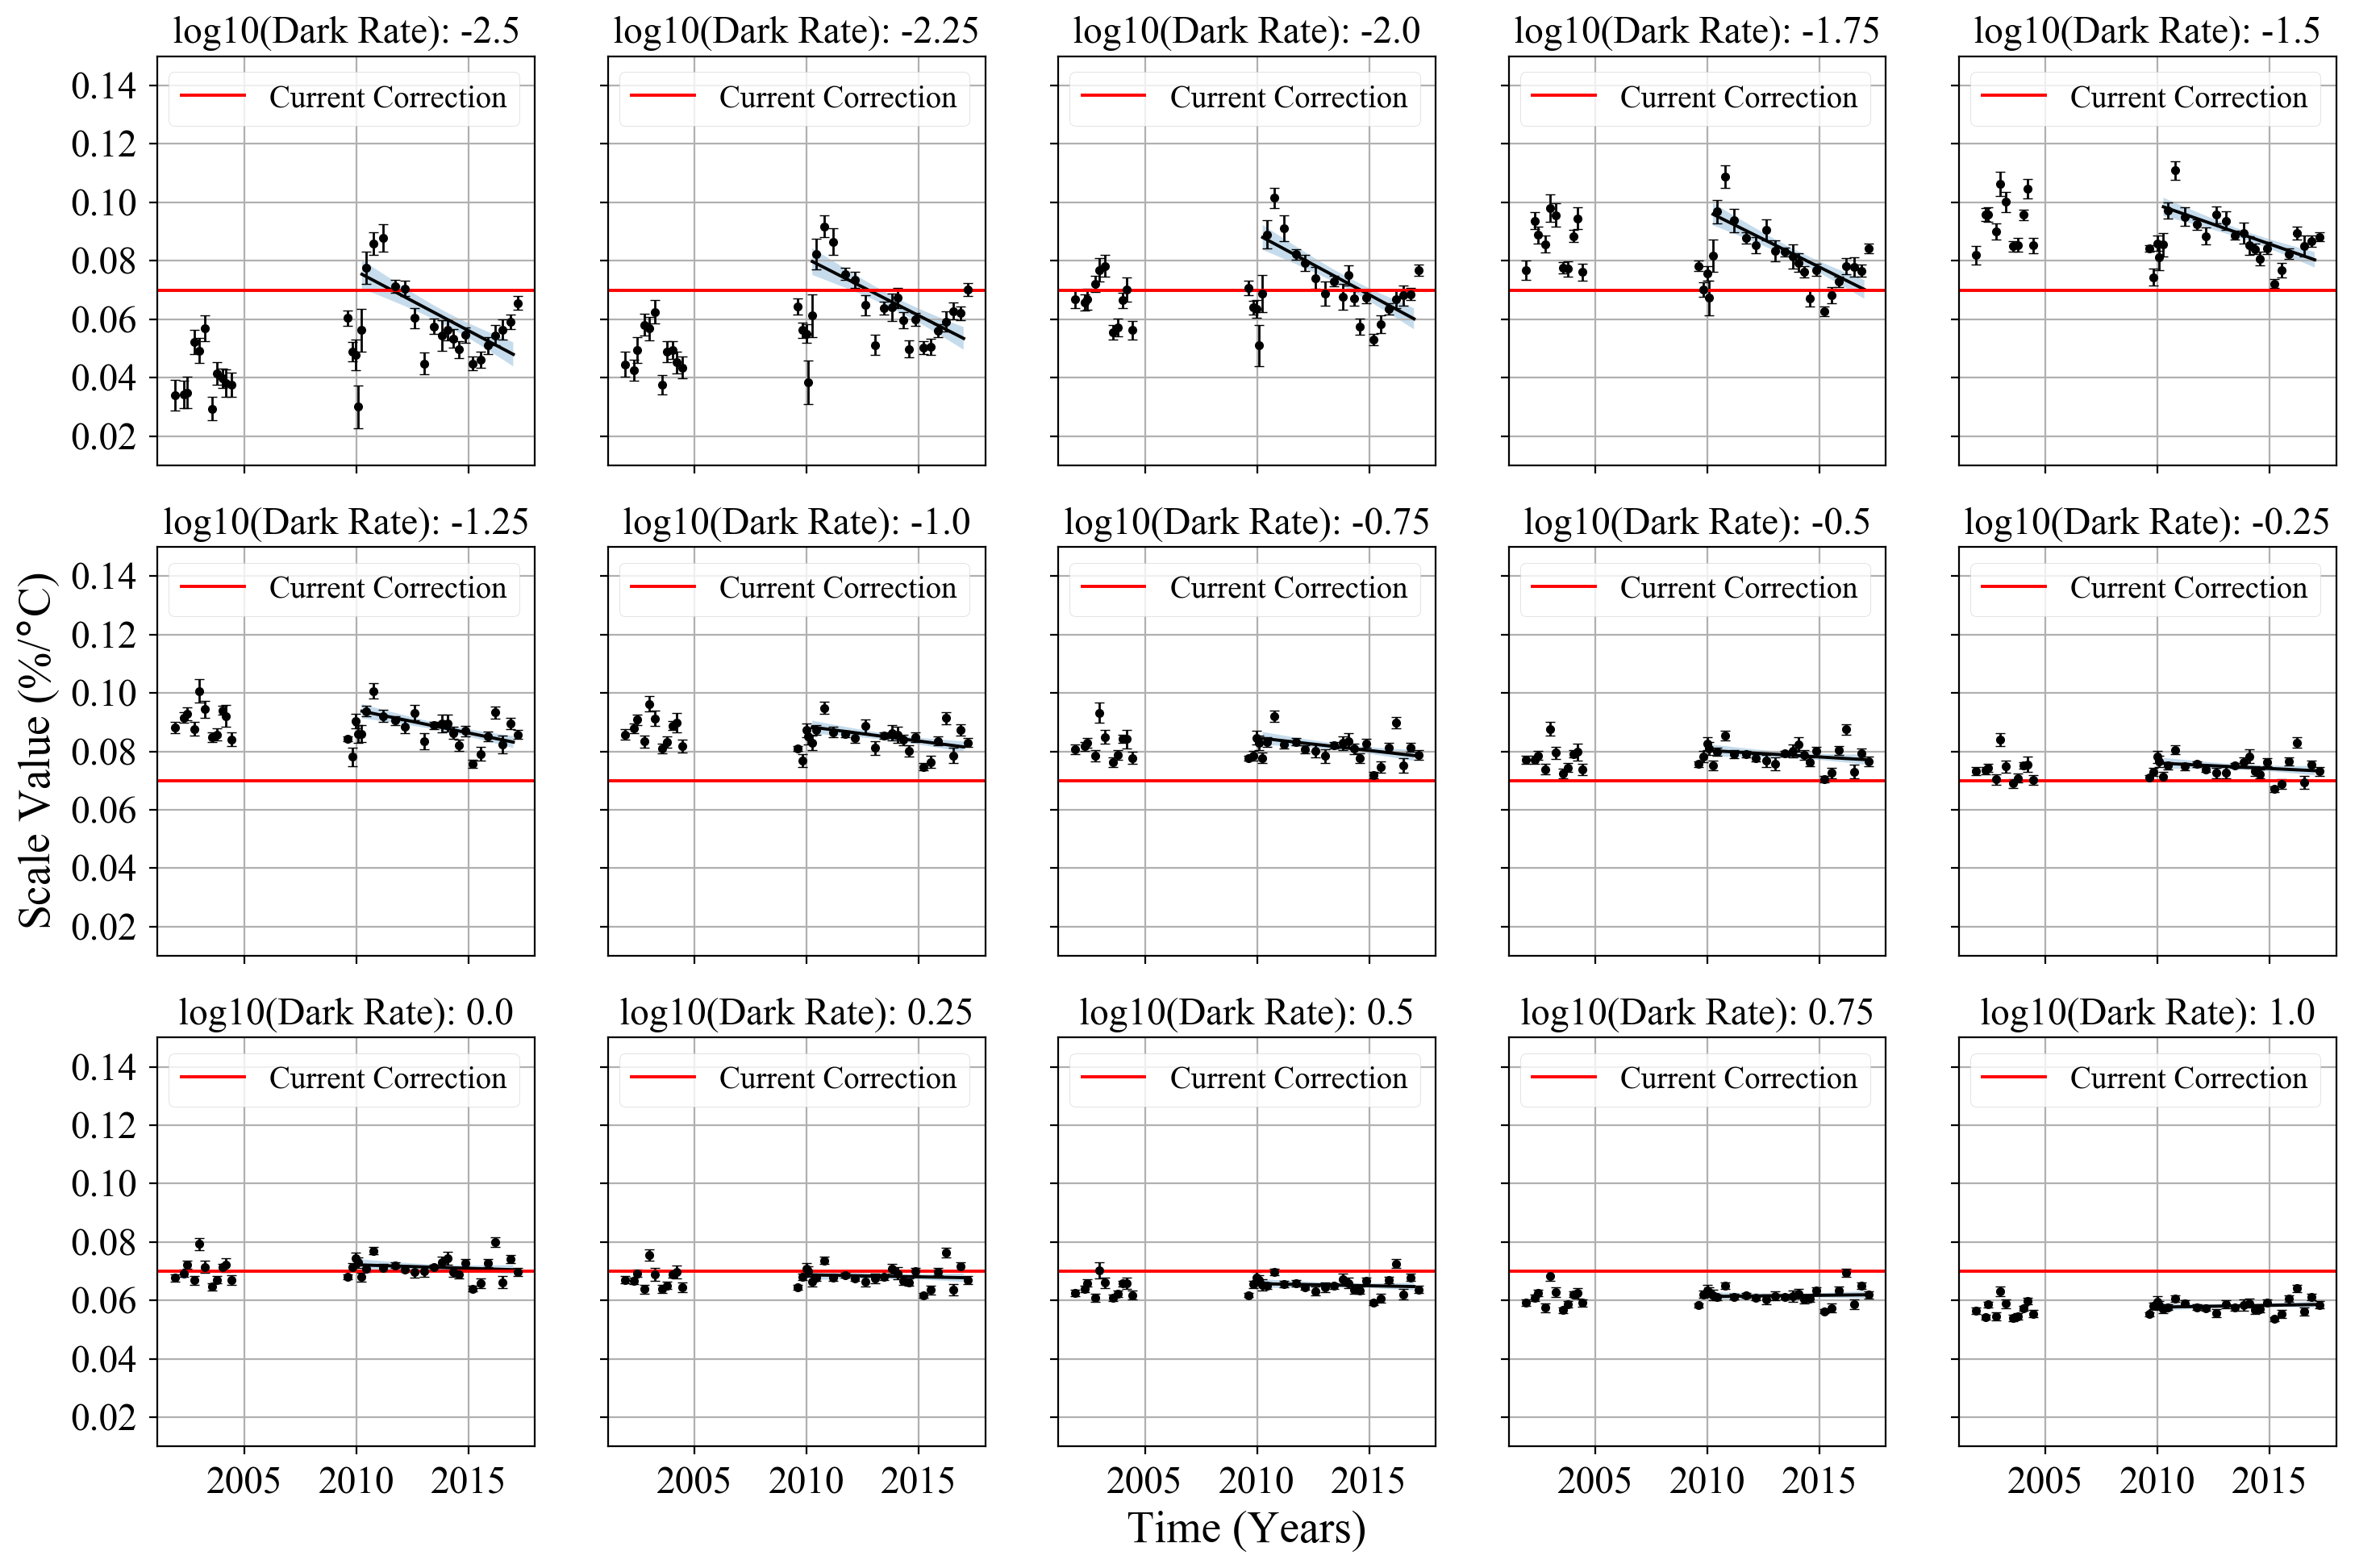

In [92]:
# Plot Time Variability of Dark Rate Temperature Scale Value

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), sharey=True, sharex=True)
fig.dpi = 200
#mpl.rc('font',**{'family':'serif','serif':['Times']})
#mpl.rc('text', usetex=True)

# Store slopes and uncertainties for populating scale value curves
postSM4_slopes= []
postSM4_unc = []

# Generate a plot for each dark rate bin
for idx, zipped in enumerate(zip(lograte_regions,axes.flatten())):
    region, ax = zipped
    #Apply a Fit to post-Servicing Mission 4 (SM4) data
    n=1 # Linear Fit
    postSM4_fit,C_p = np.polyfit(np.array(dt_stamps)[~dt_mask],region_rates[idx][~dt_mask],n,cov=True)

    p = np.poly1d(postSM4_fit)
    fitspace = np.linspace(2010.25,2017,30)
    linfit = p(fitspace)
    
    
    # Do the interpolation for plotting:
    # Matrix with rows 1, t, t**2, ...:
    TT = np.vstack([fitspace**(n-i) for i in range(n+1)]).T
    yi = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
    C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
    sig_yi = np.sqrt(np.diag(C_yi))  # Standard deviations are sqrt of diagonal

    
    postSM4_slopes.append(postSM4_fit[0])
    postSM4_unc.append(np.sqrt(C_p[0][0]))
    #pointlinewid = (preSM4_err * (20/0.1)) * 0.8 
    #ax = fig.add_subplot(3,5,idx+1)
    ax.set_title("log10(Dark Rate): "+str(region))
    ax.set_ylim(0.01,0.15)
    #preSM4_w = (preSM4_err * (20/0.14)) * 0.8
    #postSM4_w = (postSM4_err * (20/0.14)) * 0.8
    ax.errorbar(dt_stamps,region_rates[idx],yerr=region_errs[idx],fmt='o',color='k', capthick = 0.5, capsize = 2, 
                elinewidth = 1, markersize=4)
    ax.plot(fitspace,linfit,'k')
    ax.fill_between(fitspace, yi+sig_yi, yi-sig_yi, alpha=.25)
    ax.axhline(0.07,color='r',label='Current Correction')
    ax.set_xticks([2005,2010,2015])
    if region == -1.25:
        ax.set_ylabel(r"Scale Value (%/$\degree$C)")
    if region == 0.5:
        ax.set_xlabel("Time (Years)")
    ax.legend(fontsize=font_size+2)
    ax.grid(True)
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size+5)
    for item in [ax.xaxis.label, ax.yaxis.label]:
        item.set_fontsize(font_size+8)
    

#fig.text(0.5, 0.02, "Time (Years)", ha='center', fontsize = 20)
#fig.text(0.02, 0.5, r"Scale Value (%/$\degree$C)", va='center', rotation='vertical', fontsize= 20)
plt.tight_layout()
#plt.subplots_adjust(left=0.05, bottom=0.05, right=None, top=None, wspace=None, hspace=None)
plt.savefig("Plots/bin_sv_evo_paper.png")


## Time Variability of the Scale Value Curve (Post-SM4)

Pre-SM4, there is variation in the scale value for colder dark rates, but no distinct time-depedendent trend. However, in ~2010, half a year after SM4, a large spike for colder dark rates leads into a time-dependent decay trend. Below, I show how this decay affects the shape of the scale value curve.

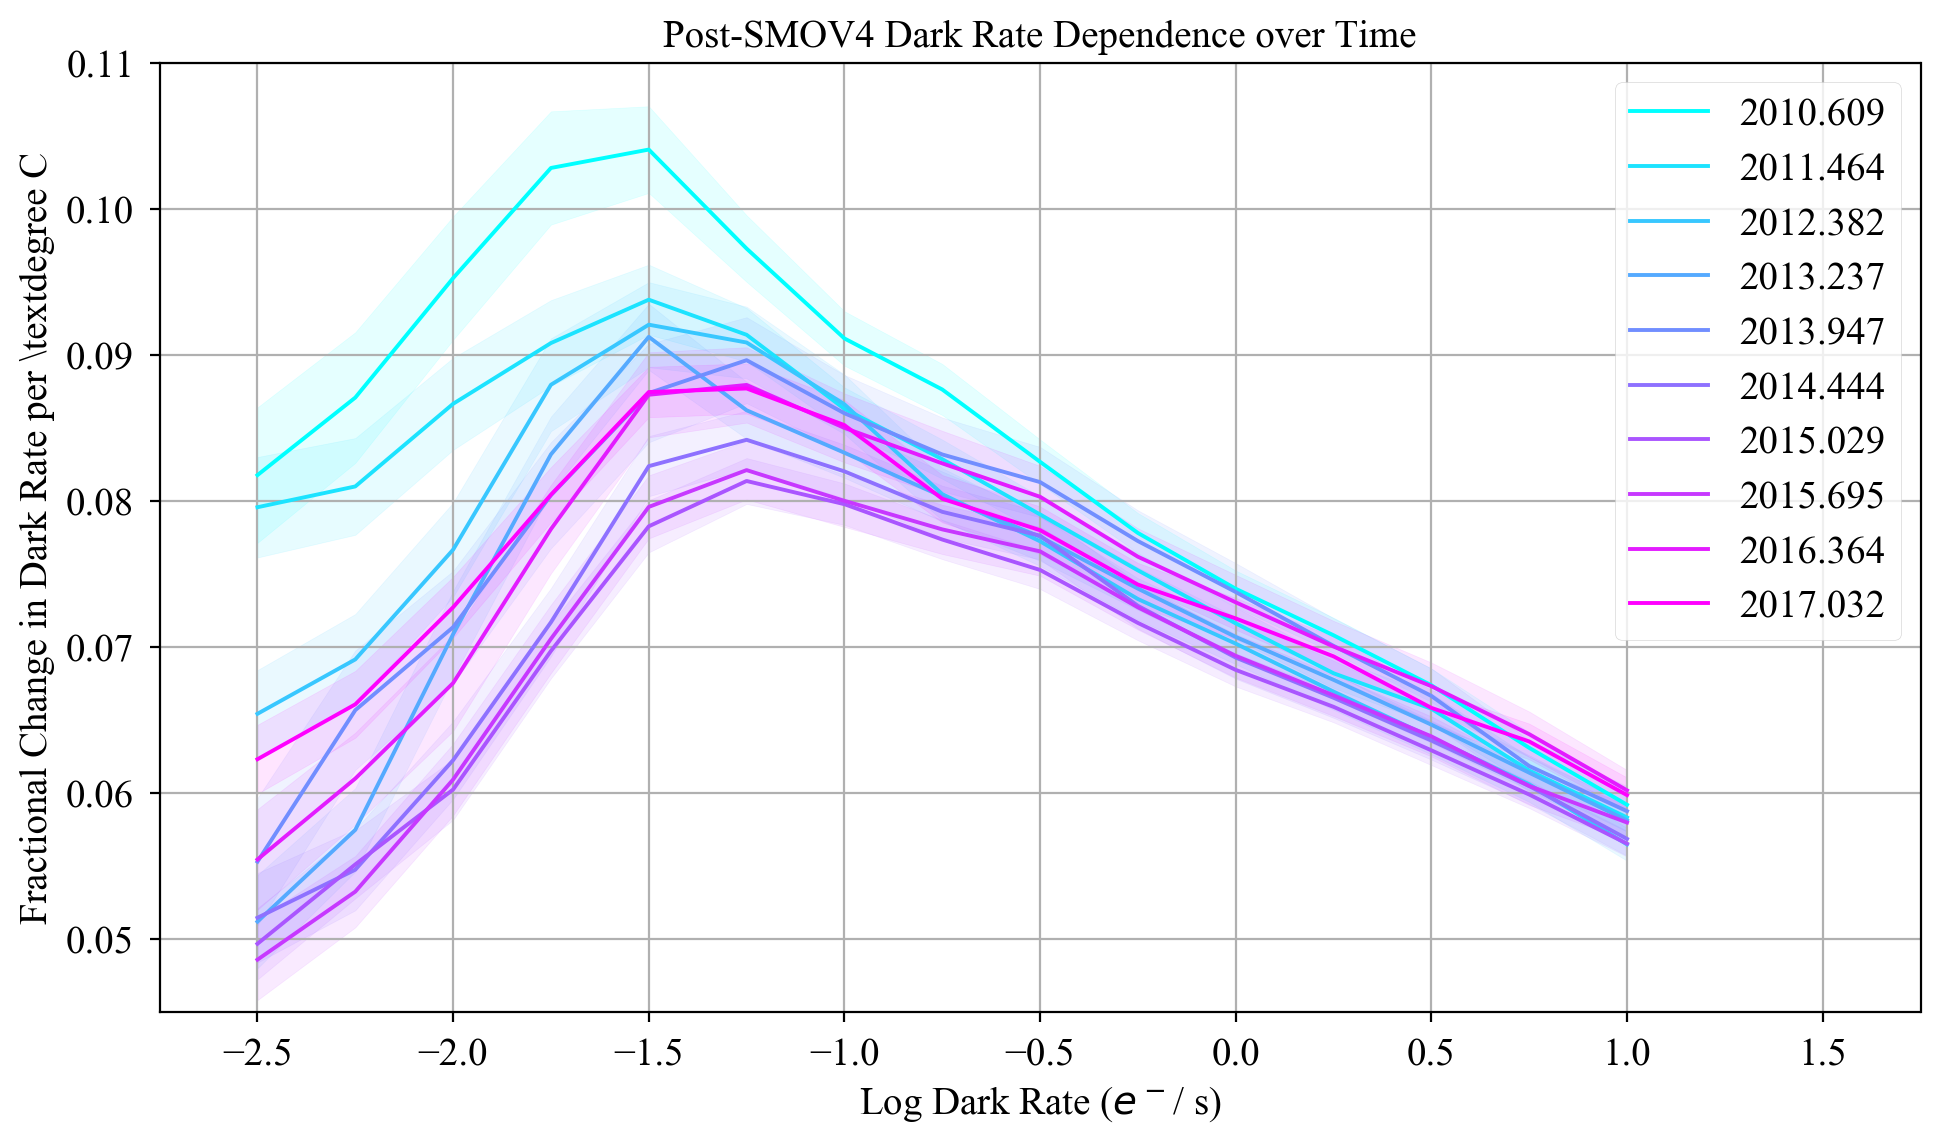

In [24]:
# Grab time stamps, scale values (and errors) and median dark rates for that time
postSM4_stamps = np.array(dt_stamps)[~dt_mask]
time_rates = np.array(region_rates).T[~dt_mask]
time_rate_errs = np.array(region_errs).T[~dt_mask]
postSM4_medrates = np.array(tsorted_rates)[~dt_mask]

#Split rates into pairs for averaging
split_rates = np.split(time_rates,10)
split_stamps = np.split(postSM4_stamps,10)
split_errs = np.split(time_rate_errs,10)
split_medrates = np.split(postSM4_medrates,10)

#Average pairs
avg_rates = [np.array(rate[0]+rate[1])/2 for rate in split_rates]
avg_errs = [np.array(err[0]+err[1])/2 for err in split_errs]
mid_stamps = [np.mean(time) for time in split_stamps]
medrates = [np.mean(rate) for rate in postSM4_medrates]

#Plot pair average scale value curves on top of each other
fig,ax = plt.subplots(figsize=(10,6))
fig.dpi=200
ratespace = np.linspace(-2.5,1,15)
color_idx = np.linspace(0, 1, 10)
ax.set_xlim(-2.75,1.75)
ax.set_ylim(0.045,0.11)

#Iterate through scale value curves
for i,rate,err,stamp,med in zip(color_idx,avg_rates,avg_errs,mid_stamps,medrates):
    ax.plot(ratespace,rate,label=str(np.round(stamp,3)),color=plt.cm.cool(i))
    ax.fill_between(ratespace, rate + err, rate - err,color=plt.cm.cool(i), alpha=.1)
    median_rate = 0.0009*(stamp-2010)+0.0125
    #ax.axvline(med, color = plt.cm.cool(i),alpha=0.5)
    
ax.legend(loc=1,fontsize=font_size+2)
ax.grid(True)
ax.set_xlabel(r"Log Dark Rate ($e^-$/ s)")
ax.set_ylabel(r"Fractional Change in Dark Rate per \textdegree C")
ax.set_title("Post-SMOV4 Dark Rate Dependence over Time")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size+2)
plt.tight_layout()

plt.savefig("smov4_curve_paper.png")

## Assessing the Perfomance of the Current 7%/&deg;C Correction

A key question in this work is to idenfity how the 7%/&deg;C has performed over time. If it has performed poorly compared to the "ideal" scale value for the time, then we would want to develop a better scaling method. So what is the ideal scale value at a given time? The best scale value should be the one that applies the best correction to the most amount of pixels. With that in mind, I've chosen to use the scale value associated with the median dark rate at a specified time (and associated scale value curve). Below, I compare these ideal scale values with the flat 7% line.

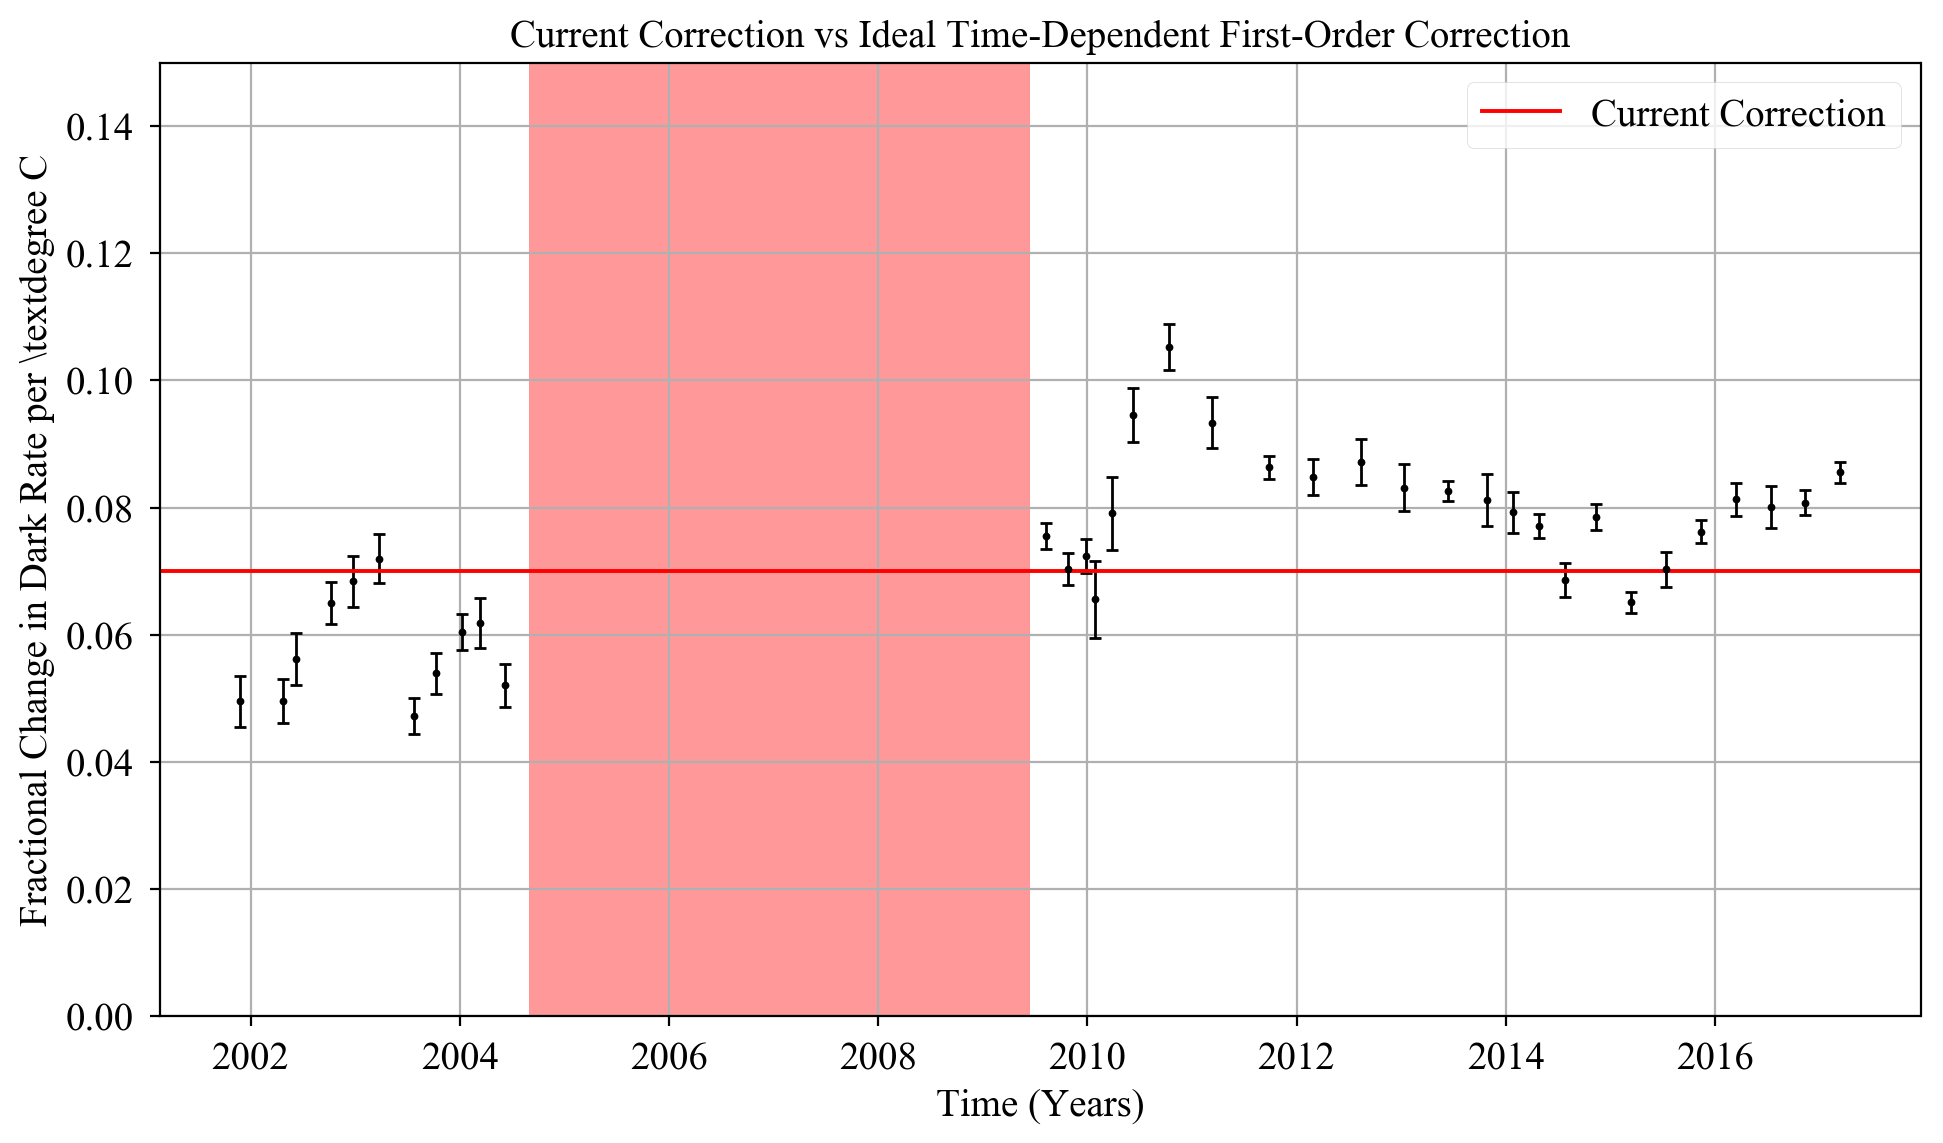

In [25]:
# Grab all time stamps, scale values (and errors) and median dark rates
all_stamps = np.array(dt_stamps)
all_time_rates = np.array(region_rates).T
all_time_rate_errs = np.array(region_errs).T
all_medrates = np.array(tsorted_rates)
ratespace = np.linspace(-2.5,1,15)

# Find scale value of the median dark rate for each time stamp, the "ideal" scale values
med_rates = []
med_errs = []
for stamp,rate,err,med in zip(all_stamps,all_time_rates,all_time_rate_errs,all_medrates):
    #z=np.polyfit(ratespace,rate,6) # Approximate scale value curve with a 6th order polynomial
    #f = np.poly1d(z)
    f = interpolate.interp1d(ratespace,rate)
    e = interpolate.interp1d(ratespace,err)
    med_rate = f(med) # Calculate scale value at the median dark rate
    med_err = e(med)
    med_rates.append(med_rate) 
    med_errs.append(med_err)

#Plot ideal scale values against 7% correction
fig,ax = plt.subplots(figsize=(10,6))
fig.dpi=200
ax.errorbar(all_stamps,med_rates,med_errs,fmt = '.', color='k',capsize=2, capthick = 1, elinewidth=1)
ax.set_title("Current Correction vs Ideal Time-Dependent First-Order Correction")
ax.set_xlabel("Time (Years)")
ax.set_ylabel(r"Fractional Change in Dark Rate per \textdegree C")
ax.set_ylim(0,0.15)
ax.fill_between([2004.66,2009.44],0,1,alpha=0.4,color='r')
ax.tick_params(axis='x',which='minor',bottom='off')
ax.grid()
ax.axhline(0.07,color='r',label='Current Correction')
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(font_size+2)
plt.tight_layout()
ax.legend(fontsize=font_size+2)
plt.savefig("plots/firstorder_perf_paper.png")

## Conclusions

For a static correction, the 7%/&deg;C correction has been a good choice as much of the variation in the ideal scale value has hovered around that point. However, at worst we've been almost 3%/&deg;C off from the ideal value. Additionally, the median dark rate has stayed colder for the lifetime of STIS, meaning that an ideal correction is subject to more time variability. Effectively, the plot above mirrors one of the colder dark rate bins found in the grid of plots at the beginning of this notebook. 

While it is unclear at this point how inaccurate our temperature correction needs to be to reflect a noticable decrease in the quality of our dark correction, the 7% correction certainly seems like it leaves much to be desired. Possible improvements to this correction could be a time-dependent first-order correction, effectively the curve describing the ideal scale values above. Though even in the ideal first-order case, we are applying a sub-optimal correction to those pixels far away from the median dark rate. So the other possibility is a second-order correction, where the scale value is computed per pixel based on time and the individual dark rate.